In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%load_ext autoreload

In [27]:
%load_ext line_profiler

In [4]:
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

In [6]:
from datahandling import DataHandler
from preprocessing import Preprocessor

In [7]:
raw_df = DataHandler().read()

In [8]:
raw_df

,Id,CumReturnResid,CumVolume,EST_VOL,MDV_63,Volume
2010-01-04 09:45:00,BBG000MQ1SN9,0.002070,43347,0.13074,4.383275e+07,955120.0
2010-01-04 09:45:00,BBG000BBCQD7,-0.012105,229661,0.31610,4.409296e+07,2566745.0
2010-01-04 09:45:00,BBG000BBB3K1,-0.001020,62697,0.11253,7.588626e+07,812905.0
2010-01-04 09:45:00,BBG000BNMHS4,0.012179,47650,0.18568,4.413393e+07,1108030.0
2010-01-04 09:45:00,BBG000C23PB0,0.003520,239259,0.11252,4.440541e+07,3500468.0
...,...,...,...,...,...,...
2014-12-31 16:00:00,BBG000BPH459,-0.003270,16810020,0.12146,1.383197e+09,21551092.0
2014-12-31 16:00:00,BBG000GZQ728,-0.000065,9221446,0.09480,1.273231e+09,11326179.0
2014-12-31 16:00:00,BBG000CKGBP2,-0.008449,11508879,0.20535,1.589295e+09,13851283.0
2014-12-31 16:00:00,BBG000MM2P62,-0.005813,18519636,0.17343,2.258944e+09,20004654.0


In [ ]:
day_sep = raw_df[["Id", "CumReturnResid"]].groupby(["Id", raw_df.index.date, raw_df.index.time>dt.time(15,30)]).last()
day_sep

In [ ]:
day_sep.xs("BBG000B9WH86", level=0)

In [ ]:
R1530_1600 = (-0.000919 +1) / (-0.002424+1) - 1
R1530_1600

In [ ]:
(R1530_1600 + 1) * (-0.039352 + 1) - 1

In [ ]:
adj_end = day_sep.add(1).groupby(level=[0, 1]).pct_change().dropna().droplevel(2)
adj_end

In [ ]:
begin = day_sep.xs(False, level=2).shift(-1)
begin

In [ ]:
target = adj_end.merge(begin, how="inner", left_index=True, right_index=True).stack().add(1).groupby(level=[0, 1]).prod().sub(1).rename("Target").to_frame()

In [ ]:
target

In [ ]:
target.sort_index().unstack().T

In [49]:
target_2 = Preprocessor(raw_df).create_target()

<AxesSubplot:ylabel='Frequency'>

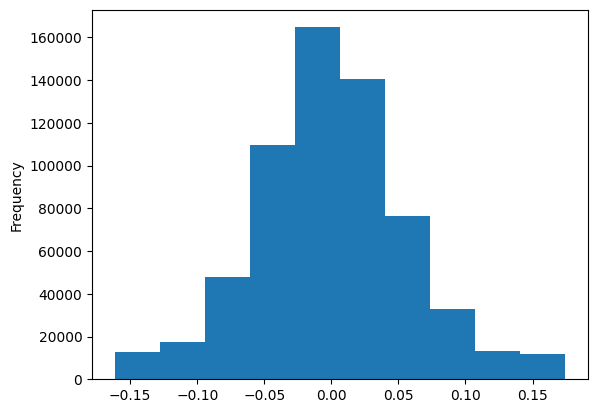

In [50]:
target_2.plot(kind="hist")

In [52]:
target_2.to_frame()

Target
Id                                         
BBG000B9WH86           2010-01-04 -0.161663
                       2010-01-05  0.143294
                       2010-01-06 -0.102812
                       2010-01-07 -0.044104
                       2010-01-08  0.119874
...                                     ...
GEN_EQ0140919900001000 2011-01-12  0.061040
                       2011-01-13  0.071008
                       2011-01-14  0.033858
                       2011-01-18 -0.000999
                       2011-01-19 -0.005147

[626431 rows x 1 columns]

In [249]:
target_2

Id                                
BBG000B9WH86            2010-01-04   -0.161663
                        2010-01-05    0.143294
                        2010-01-06   -0.102812
                        2010-01-07   -0.044104
                        2010-01-08    0.119874
                                        ...   
GEN_EQ0140919900001000  2011-01-12    0.061040
                        2011-01-13    0.071008
                        2011-01-14    0.033858
                        2011-01-18   -0.000999
                        2011-01-19   -0.005147
Name: Target, Length: 626431, dtype: float64

In [18]:
raw_df2 = DataHandler().read(end="2010-06-01")

In [ ]:
volume = raw_df2[["Id", "CumVolume"]].groupby(["Id", raw_df2.index.date, raw_df2.index.time>=dt.time(10,0)]).last()
volume

In [ ]:
total_intra = volume.groupby(level=[0,1]).sum()
total_intra

In [ ]:
after10_vol = volume.groupby(level=[0,1]).diff()

In [ ]:
after10_vol

In [ ]:
total_vol = raw_df2.groupby(["Id", raw_df2.index.date])["Volume"].first().astype(int).to_frame()
total_vol

In [ ]:
vol_diff = total_intra.merge(total_vol, how="outer", left_index=True, right_index=True)

In [ ]:
((vol_diff["CumVolume"] - vol_diff["Volume"]).abs() / vol_diff["Volume"]).plot()

In [ ]:
raw_df2

In [235]:
tickdata = Preprocessor(raw_df).create_raw_tick_features()

In [236]:
tickdata

ResidReturn     Volume
Id                                                                
BBG000B9WH86           2010-01-04 09:45:00    -0.003154  2030006.0
                       2010-01-04 10:00:00     0.000714  1925345.0
                       2010-01-04 10:15:00     0.008988  2305353.0
                       2010-01-04 10:30:00     0.003198  1975358.0
                       2010-01-04 10:45:00    -0.004022  1658851.0
...                                                 ...        ...
GEN_EQ0140919900001000 2011-01-19 15:00:00    -0.000184    57037.0
                       2011-01-19 15:15:00     0.000293    51932.0
                       2011-01-19 15:30:00    -0.000292    47769.0
                       2011-01-19 15:45:00     0.000009   104316.0
                       2011-01-19 16:00:00    -0.000397   195984.0

[16354000 rows x 2 columns]

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
from datahandling import DataHandler
from preprocessing import Preprocessor

In [ ]:
raw_df = DataHandler().read()

In [253]:
dataset = Preprocessor(raw_df).run()

In [254]:
dataset

ResidReturn-100  ResidReturn-99  \
BBG000B9WH86           2010-01-04              NaN             NaN   
                       2010-01-05              NaN             NaN   
                       2010-01-06              NaN             NaN   
                       2010-01-07         0.008988        0.003198   
                       2010-01-08        -0.006303       -0.007469   
...                                            ...             ...   
GEN_EQ0140919900001000 2011-01-12         0.003311        0.001054   
                       2011-01-13         0.000151       -0.001638   
                       2011-01-14         0.002291       -0.000399   
                       2011-01-18         0.000299        0.000193   
                       2011-01-19         0.002562        0.001884   

                                   ResidReturn-98  ResidReturn-97  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.004022       -0.002223   
                       2010-01-08       -0.004237       -0.002924   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.003590       -0.002187   
                       2011-01-13       -0.000915       -0.004111   
                       2011-01-14       -0.001135       -0.000462   
                       2011-01-18        0.000844       -0.000231   
                       2011-01-19        0.000006       -0.000344   

                                   ResidReturn-96  ResidReturn-95  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.003723        0.002291   
                       2010-01-08        0.003992       -0.006546   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12       -0.000226        0.001822   
                       2011-01-13       -0.003805        0.000380   
                       2011-01-14        0.001003       -0.000665   
                       2011-01-18        0.000129        0.001274   
                       2011-01-19       -0.001029       -0.000653   

                                   ResidReturn-94  ResidReturn-93  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07        0.000358       -0.000936   
                       2010-01-08       -0.001019       -0.004630   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.000579        0.000257   
                       2011-01-13       -0.000857        0.001728   
                       2011-01-14       -0.000341        0.000053   
                       2011-01-18        0.000639        0.000886   
                       2011-01-19       -0.000639       -0.000483   

                                   ResidReturn-92  ResidReturn-91  ...  \
BBG000B9WH86           2010-01-04             NaN             NaN  ...   
                       2010-01-05             NaN             NaN  ...   
                       2010-01-06             NaN             NaN  ...   
                       2010-01-07       -0.002694        0.000599  ...   
                       2010-01-08        0.003445       -0.000442  ...   
...                                           ...             ...  ...   
GEN_EQ0140919900001000 2011-01-12        0.000200       -0.001509  ...   
                       2011-01-13        0.000430       -0.000968  ...   
                       2011-01-14       -

In [250]:
target_2.index.rename(None, level=0, inplace=True)

In [251]:
features.merge(target_2, left_index=True, right_index=True)

ResidReturn-100  ResidReturn-99  \
BBG000B9WH86           2010-01-04              NaN             NaN   
                       2010-01-05              NaN             NaN   
                       2010-01-06              NaN             NaN   
                       2010-01-07         0.008988        0.003198   
                       2010-01-08        -0.006303       -0.007469   
...                                            ...             ...   
GEN_EQ0140919900001000 2011-01-12         0.003311        0.001054   
                       2011-01-13         0.000151       -0.001638   
                       2011-01-14         0.002291       -0.000399   
                       2011-01-18         0.000299        0.000193   
                       2011-01-19         0.002562        0.001884   

                                   ResidReturn-98  ResidReturn-97  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.004022       -0.002223   
                       2010-01-08       -0.004237       -0.002924   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.003590       -0.002187   
                       2011-01-13       -0.000915       -0.004111   
                       2011-01-14       -0.001135       -0.000462   
                       2011-01-18        0.000844       -0.000231   
                       2011-01-19        0.000006       -0.000344   

                                   ResidReturn-96  ResidReturn-95  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.003723        0.002291   
                       2010-01-08        0.003992       -0.006546   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12       -0.000226        0.001822   
                       2011-01-13       -0.003805        0.000380   
                       2011-01-14        0.001003       -0.000665   
                       2011-01-18        0.000129        0.001274   
                       2011-01-19       -0.001029       -0.000653   

                                   ResidReturn-94  ResidReturn-93  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07        0.000358       -0.000936   
                       2010-01-08       -0.001019       -0.004630   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.000579        0.000257   
                       2011-01-13       -0.000857        0.001728   
                       2011-01-14       -0.000341        0.000053   
                       2011-01-18        0.000639        0.000886   
                       2011-01-19       -0.000639       -0.000483   

                                   ResidReturn-92  ResidReturn-91  ...  \
BBG000B9WH86           2010-01-04             NaN             NaN  ...   
                       2010-01-05             NaN             NaN  ...   
                       2010-01-06             NaN             NaN  ...   
                       2010-01-07       -0.002694        0.000599  ...   
                       2010-01-08        0.003445       -0.000442  ...   
...                                           ...             ...  ...   
GEN_EQ0140919900001000 2011-01-12        0.000200       -0.001509  ...   
                       2011-01-13        0.000430       -0.000968  ...   
                       2011-01-14       -

In [181]:
tickdata.xs("BBG000B9WH86", level=0).iloc[14:24]

,ResidReturn,Volume
2010-01-04 13:15:00,-0.002120,622746.0
2010-01-04 13:30:00,0.000755,345898.0
2010-01-04 13:45:00,0.000754,262032.0
2010-01-04 14:00:00,-0.000809,624198.0
2010-01-04 14:15:00,-0.000743,622236.0
2010-01-04 14:30:00,-0.000077,479240.0
2010-01-04 14:45:00,0.000092,638528.0
2010-01-04 15:00:00,-0.000943,426204.0
2010-01-04 15:15:00,-0.000917,555196.0
2010-01-04 15:30:00,-0.000958,532948.0


In [81]:
for (Id, date), daily_data in raw_df.groupby(["Id", raw_df.index.date]):
    d = daily_data
    if d.index[0].time() != dt.time(9, 45):
        print(f"id {Id} has starts late ({d.index[0].time()}) on day {date}")
        break
    if d.index[-1].time() != dt.time(16, 0):
         print(f"id {Id} has ends early ({d.index[-1].time()}) on day {date}")
            
    if (d.index != pd.date_range(start=d.index[0], end=d.index[-1], freq='15T', inclusive="both")).any():
        print(f"id {Id} has discontinuous data on day {date}")
        break
        
print("No bad data found")

No bad_data_found


In [237]:
def strided_app(a, L):
    nrows = ((a.size-L))+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(n,n))

In [238]:
window = 100
data = []
for Id, id_data in tickdata.groupby(level=0):
    start_index = id_data.index.get_level_values(1)[0]
    filled_up_index = pd.date_range(start=start_index - pd.DateOffset(minutes=15*window), end=start_index, freq="15T", inclusive="left")
    filled_up_df = pd.DataFrame(np.nan, index=pd.MultiIndex.from_arrays([[Id] * len(filled_up_index), filled_up_index]), columns=id_data.columns)
    id_data = pd.concat([filled_up_df, id_data])
    arr = np.stack([strided_app(id_data["ResidReturn"].to_numpy(copy=False),L=window), strided_app(id_data["Volume"].to_numpy(copy=False),L=window)], axis=1)
    mask = id_data.index[window-1:].get_level_values(1).time == dt.time(15,30)
    days = id_data.index[window-1:].get_level_values(1)[mask].date
    data.append(pd.DataFrame(arr[mask].reshape(-1, window * 2), index=pd.MultiIndex.from_arrays([[Id] * len(days), days])))

In [240]:
features = pd.concat(data)
features.columns = ["ResidReturn-" + str(i) for i in range(features.shape[1]//2, 0, -1)] + ["Volume-" + str(i) for i in range(features.shape[1]//2, 0, -1)]
features.sort_index()

ResidReturn-100  ResidReturn-99  \
BBG000B9WH86           2010-01-04              NaN             NaN   
                       2010-01-05              NaN             NaN   
                       2010-01-06              NaN             NaN   
                       2010-01-07         0.008988        0.003198   
                       2010-01-08        -0.006303       -0.007469   
...                                            ...             ...   
GEN_EQ0140919900001000 2011-01-12         0.003311        0.001054   
                       2011-01-13         0.000151       -0.001638   
                       2011-01-14         0.002291       -0.000399   
                       2011-01-18         0.000299        0.000193   
                       2011-01-19         0.002562        0.001884   

                                   ResidReturn-98  ResidReturn-97  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.004022       -0.002223   
                       2010-01-08       -0.004237       -0.002924   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.003590       -0.002187   
                       2011-01-13       -0.000915       -0.004111   
                       2011-01-14       -0.001135       -0.000462   
                       2011-01-18        0.000844       -0.000231   
                       2011-01-19        0.000006       -0.000344   

                                   ResidReturn-96  ResidReturn-95  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07       -0.003723        0.002291   
                       2010-01-08        0.003992       -0.006546   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12       -0.000226        0.001822   
                       2011-01-13       -0.003805        0.000380   
                       2011-01-14        0.001003       -0.000665   
                       2011-01-18        0.000129        0.001274   
                       2011-01-19       -0.001029       -0.000653   

                                   ResidReturn-94  ResidReturn-93  \
BBG000B9WH86           2010-01-04             NaN             NaN   
                       2010-01-05             NaN             NaN   
                       2010-01-06             NaN             NaN   
                       2010-01-07        0.000358       -0.000936   
                       2010-01-08       -0.001019       -0.004630   
...                                           ...             ...   
GEN_EQ0140919900001000 2011-01-12        0.000579        0.000257   
                       2011-01-13       -0.000857        0.001728   
                       2011-01-14       -0.000341        0.000053   
                       2011-01-18        0.000639        0.000886   
                       2011-01-19       -0.000639       -0.000483   

                                   ResidReturn-92  ResidReturn-91  ...  \
BBG000B9WH86           2010-01-04             NaN             NaN  ...   
                       2010-01-05             NaN             NaN  ...   
                       2010-01-06             NaN             NaN  ...   
                       2010-01-07       -0.002694        0.000599  ...   
                       2010-01-08        0.003445       -0.000442  ...   
...                                           ...             ...  ...   
GEN_EQ0140919900001000 2011-01-12        0.000200       -0.001509  ...   
                       2011-01-13        0.000430       -0.000968  ...   
                       2011-01-14       -

In [199]:
arr[mask].reshape(-1, window * 2)[0]

array([-2.12025984e-03,  7.54977515e-04,  7.53627841e-04, -8.08521168e-04,
       -7.42566358e-04, -7.70469321e-05,  9.21577741e-05, -9.42561485e-04,
       -9.16620296e-04, -9.58433519e-04,  6.22746000e+05,  3.45898000e+05,
        2.62032000e+05,  6.24198000e+05,  6.22236000e+05,  4.79240000e+05,
        6.38528000e+05,  4.26204000e+05,  5.55196000e+05,  5.32948000e+05])

In [191]:
data["BBG000B9WH86"][0]

array([[-2.12025984e-03,  7.54977515e-04,  7.53627841e-04,
        -8.08521168e-04, -7.42566358e-04, -7.70469321e-05,
         9.21577741e-05, -9.42561485e-04, -9.16620296e-04,
        -9.58433519e-04],
       [ 6.22746000e+05,  3.45898000e+05,  2.62032000e+05,
         6.24198000e+05,  6.22236000e+05,  4.79240000e+05,
         6.38528000e+05,  4.26204000e+05,  5.55196000e+05,
         5.32948000e+05]])

In [193]:
index["BBG000B9WH86"][0]

datetime.date(2010, 1, 4)

In [97]:
len(oui)

566

In [89]:
w.shape

(2677991, 10)

In [ ]:
tickdata.xs("BBG000B9WH86", level=0)

In [ ]:
eval_copy_tick = tickdata.copy()
eval_copy_tick["ResidReturn"] = eval_copy_tick["ResidReturn"].add(1)
grouped_tick = eval_copy_tick.groupby([pd.Grouper(level=0), pd.Grouper(freq='1D', level=1)])
agg_day_tick = pd.concat([grouped_tick["ResidReturn"].prod().sub(1), grouped_tick["Volume"].sum().astype(int)], axis=1)
agg_day_tick

In [ ]:
real_agg = raw_df2[["Id", "CumReturnResid", "CumVolume"]].groupby(["Id", raw_df2.index.date]).last()
real_agg

In [ ]:
sub_tickdata = tickdata.iloc[:10000]

In [ ]:
sub_tickdata

In [21]:
tick_by_id_dict = {Id: data.copy().droplevel(0) for Id, data in tickdata.groupby(level=0)}

In [22]:
tick_by_id_dict

{'BBG000B9WH86':                      ResidReturn     Volume
 2010-01-04 09:45:00    -0.003154  2030006.0
 2010-01-04 10:00:00     0.000714  1925345.0
 2010-01-04 10:15:00     0.008988  2305353.0
 2010-01-04 10:30:00     0.003198  1975358.0
 2010-01-04 10:45:00    -0.004022  1658851.0
 ...                          ...        ...
 2010-06-01 15:00:00    -0.000606   620328.0
 2010-06-01 15:15:00     0.001323   545352.0
 2010-06-01 15:30:00    -0.002799   976552.0
 2010-06-01 15:45:00     0.003175  1444508.0
 2010-06-01 16:00:00    -0.002645  2614424.0
 
 [2678 rows x 2 columns],
 'BBG000B9WJ73':                      ResidReturn    Volume
 2010-01-04 09:45:00     0.000509  186659.0
 2010-01-04 10:00:00    -0.001401  221822.0
 2010-01-04 10:15:00     0.006971  236655.0
 2010-01-04 10:30:00    -0.001392   94004.0
 2010-01-04 10:45:00     0.003960  167857.0
 ...                          ...       ...
 2010-06-01 15:00:00    -0.002138  172276.0
 2010-06-01 15:15:00    -0.001021  249859.0
 201

In [23]:
num_days = 5
feat = ["ResidReturn", "Volume"]


In [53]:
pd.bdate_range(start=end_day - pd.DateOffset(days=num_days), end=end_day, freq='15T', inclusive="right")

DatetimeIndex(['2010-05-27 00:15:00', '2010-05-27 00:30:00',
               '2010-05-27 00:45:00', '2010-05-27 01:00:00',
               '2010-05-27 01:15:00', '2010-05-27 01:30:00',
               '2010-05-27 01:45:00', '2010-05-27 02:00:00',
               '2010-05-27 02:15:00', '2010-05-27 02:30:00',
               ...
               '2010-05-31 21:45:00', '2010-05-31 22:00:00',
               '2010-05-31 22:15:00', '2010-05-31 22:30:00',
               '2010-05-31 22:45:00', '2010-05-31 23:00:00',
               '2010-05-31 23:15:00', '2010-05-31 23:30:00',
               '2010-05-31 23:45:00', '2010-06-01 00:00:00'],
              dtype='datetime64[ns]', length=480, freq='15T')

In [31]:
def compute_id(features_dict, Id, id_data):
    for day, daily_data in id_data.groupby(pd.Grouper(level=0, freq='D')):
        end_day = day + pd.DateOffset(hours=15, minutes=30)
        dates = pd.date_range(start=end_day - pd.DateOffset(days=num_days), end=end_day, freq='15T', inclusive="right")
        day_features = pd.DataFrame(np.nan, 
                 index=dates, 
                 columns=feat)
        features_dict[(day, Id)]= day_features.fillna(id_data).unstack().droplevel(0).values

In [44]:
def prof_function(tick_by_id_data):
    features_dict = {}
    Id, id_data = list(tick_by_id_data.items())[0]
    for day, daily_data in id_data.groupby(pd.Grouper(level=0, freq='D')):
        end_day = day + pd.DateOffset(hours=15, minutes=30)
        dates = pd.date_range(start=end_day - pd.DateOffset(days=num_days), end=end_day, freq='15T', inclusive="right")
        day_features = pd.DataFrame(np.nan, 
                 index=dates, 
                 columns=feat)
        day_features = id_data[]
        unstacked = filled.unstack().droplevel(0).values
        features_dict[(day, Id)]= unstacked

In [45]:
%lprun -f prof_function prof_function(tick_by_id_dict)

In [ ]:
tick_by_id_data

In [ ]:
features_dict = {}
for Id, id_data in next(tick_by_id_dict.items()):
    compute_id(feature_dict, Id, id_data)

In [24]:
features_dict = {}
for Id, id_data in tick_by_id_dict.items():
    compute_id(feature_dict, Id, id_data)

In [25]:
features = pd.DataFrame.from_dict(features_dict, orient="index")
features.index = pd.MultiIndex.from_tuples(features.index)
features.columns =[f + "-" + str(i) for f in feat for i in range(num_rows, 0, -1)]

In [26]:
features

,,ResidReturn-480,ResidReturn-479,ResidReturn-478,ResidReturn-477,ResidReturn-476,ResidReturn-475,ResidReturn-474,ResidReturn-473,ResidReturn-472,ResidReturn-471,...,Volume-10,Volume-9,Volume-8,Volume-7,Volume-6,Volume-5,Volume-4,Volume-3,Volume-2,Volume-1
2010-01-04,BBG000B9WH86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,622746.0,345898.0,262032.0,624198.0,622236.0,479240.0,638528.0,426204.0,555196.0,532948.0
2010-01-05,BBG000B9WH86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1785408.0,1444078.0,1633268.0,1173908.0,958860.0,1226916.0,839420.0,1618820.0,989356.0,1671564.0
2010-01-06,BBG000B9WH86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,760084.0,776374.0,1447970.0,1747644.0,4324632.0,1361644.0,2031008.0,1299580.0,1216756.0,863908.0
2010-01-07,BBG000B9WH86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1050250.0,890040.0,488080.0,560392.0,529442.0,514620.0,799742.0,747668.0,1267558.0,1719076.0
2010-01-08,BBG000B9WH86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,664456.0,1784022.0,851998.0,893060.0,858944.0,690730.0,707646.0,1213532.0,1057124.0,1274462.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-28,GEN_EQ0140919900001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16591.0,20174.0,27907.0,28835.0,48186.0,32070.0,30819.0,75418.0,52697.0,91617.0
2010-05-29,GEN_EQ0140919900001000,-0.000219,-0.000188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-30,GEN_EQ0140919900001000,-0.000546,-0.001281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-31,GEN_EQ0140919900001000,0.000094,-0.000240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
day

In [ ]:
ids

In [ ]:
day

In [ ]:
# window size
num_days = 10
# list of pd.series for every day
features_list = []

# iterating over every day

for day, data in tickdata.reset_index(0).groupby(pd.Grouper(level=0, freq='D')):
    # get the current day cutoff (15:30)
    end_day = day + pd.DateOffset(hours=15, minutes=30)
    # get the ids present that day
    ids = list(data["Id"].unique())
    # date range from - num_days  
    dates = list(pd.date_range(start=end_day - pd.DateOffset(days=num_days), end=end_day, freq='15T', inclusive="right"))
    # features
    feat = ["ResidReturn", "Volume"]
    # creating a nan dataframe (which is in fact with single row), that has the correct size 
    # (every 15min possible during num_days in the past)
    # that way, we can fill it with correct values
    day_features = pd.DataFrame(np.nan, 
                 index=pd.MultiIndex.from_tuples(product(*[ids, dates]), names=["Id", None]), 
                 columns = feat)
    # filling up the values if they exist
    day_features.fillna(tickdata,inplace=True)
    # replacing the datetime index by a general index (each feature with num of 15minutes in the past)
    new_index = [f + "-" + str(i) for f in feat for i in range(num_rows, 0, -1)]
    day_features.index = day_features.index.set_levels(new_index, level=1)
    # removing the "feat" multiindex level and unstacking things to have a single row
    # naming the row name as the date
    features_list.append(day_features.unstack(level=[0,1]).droplevel(0, axis=0).rename(day.date()).to_frame())

In [ ]:
features_list = []
for day, data in tickdata.reset_index(0).groupby(pd.Grouper(level=0, freq='D')):
    for id, data
    end_day = day + pd.DateOffset(hours=15, minutes=30)
    ids = list(data["Id"].unique())
    dates = list(pd.date_range(start=end_day - pd.DateOffset(days=num_days), end=end_day, freq='15T', inclusive="right"))
    feat = ["ResidReturn", "Volume"]
    day_features = pd.DataFrame(np.nan, 
                 index=pd.MultiIndex.from_tuples(product(*[ids, dates]), names=["Id", None]), 
                 columns = feat)
    day_features.fillna(tickdata,inplace=True)
    new_index = [f + "-" + str(i) for f in feat for i in range(num_rows, 0, -1)]
    day_features.index = day_features.index.set_levels(new_index, level=1)
    features_list.append(day_features.unstack(level=[0,1]).droplevel(0, axis=0).rename(day.date()).to_frame())

In [ ]:
pd.concat(features_list).T.sort_index()

In [ ]:
features_list[0]

In [ ]:
pd.concat()

In [ ]:
list(product(*[ids, feat, dates]))

In [ ]:
day_features

In [ ]:
ids

In [ ]:
d

In [ ]:
for ticker, data in sub_tickdata.reset_index(level=0).groupby("Id"):
    ticker_data = data.drop("Id", axis=1)
    index1530 = ticker_data.index[ticker_data.index.time == dt.time(15, 30)]
    idx = index1530[0]
    
    break

In [ ]:
ticker_data.loc[idx - pd.DateOffset(days=num_days):idx]

In [ ]:
features_dict = []
for ticker, data in sub_tickdata.reset_index(level=0).groupby("Id"):
    ticker_data = data.drop("Id", axis=1)
    index1530 = ticker_data.index[ticker_data.index.time == dt.time(15, 30)]
    for idx in index1530:
        #features_dict[(ticker,idx.date())] = 
        features_dict.append(ticker_data.loc[idx - pd.DateOffset(days=num_days):idx].resample('15T').first().unstack())

In [ ]:
features_dict

In [ ]:
pd.concat(features_dict, axis=1)

In [ ]:
return_dict = {i: f"ReturnResid-{num_rows - i}" for i in range(num_rows+1)} 
volume_dict = {i+num_rows: f"Volume-{num_rows - i}" for i in range(num_rows+1)}
column_map = {**return_dict, **volume_dict}

In [ ]:
features = pd.DataFrame.from_dict(features_dict, orient = "index").rename(columns=column_map)
features.index = pd.MultiIndex.from_tuples(features.index)
features.dropna()

In [ ]:
sub_tickdata.rolling('20D').filter(lambda x: x.index[-1].time() == dt.time(15, 30))

In [ ]:
tickdata.iloc[:10000].reset_index(level=0).groupby("Id").rolling(20)

In [ ]:
genX = ({(Id, roll.index[-1].date()): roll[["ResidReturn", "Volume"]].values} for Id, group in tickdata.iloc[:1000].reset_index(level=0).groupby("Id") for roll in group.rolling('20D') if roll.index[-1].time() == dt.time(15, 30))

In [ ]:
reduce(lambda r, d: r.update(d) or r, genX, {})

In [ ]:
pd.DataFrame.from_dict(), orient="index")

In [ ]:
from functools import reduce

In [ ]:
non = (data for data in sub_tick_data.groupby("Id"))

In [ ]:
next(non)